In [1]:
%pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [140]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
import segmentation_models_pytorch as smp
import torchmetrics
from poutyne import Model, ModelCheckpoint, CSVLogger, set_seeds
from torch.utils.data import DataLoader
from PIL import Image


def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor


def plot_images(images, num_per_row=8, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig


# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [141]:
learning_rate = 0.0005
batch_size = 64
image_size = 224
num_epochs = 100
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing
set_seeds(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda


In [142]:
input_resize = transforms.Resize((224, 224))
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_resize = transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

# Creating the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)
valid_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)
test_dataset = datasets.VOCSegmentation(
    './data/VOC/',
    year='2007',
    download=True,
    image_set='test',
    transform=input_transform,
    target_transform=target_transform,
)

# Creating the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/
Using downloaded and verified file: ./data/VOC/VOCtest_06-Nov-2007.tar
Extracting ./data/VOC/VOCtest_06-Nov-2007.tar to ./data/VOC/


In [143]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# Define transformations for input and target
input_resize = transforms.Resize((224, 224))
input_transform = transforms.Compose([
    input_resize,
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

target_resize = transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST)
target_transform = transforms.Compose([
    target_resize,
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
])

# Load complete datasets
complete_train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

complete_val_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

# Combine datasets
total_dataset = torch.utils.data.ConcatDataset([complete_train_dataset, complete_val_dataset])

# Determine split sizes
total_size = len(total_dataset)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size  # Adjust test size to cover any rounding off issues

# Split dataset
train_dataset, valid_dataset, test_dataset = random_split(total_dataset, [train_size, valid_size, test_size])

# Define dataloaders
batch_size = 16  # Set the batch size you want
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/


In [144]:
print(test_dataset)
print(train_dataset)
print(valid_dataset)

#  150 from validation to train

# 147 from test to trian


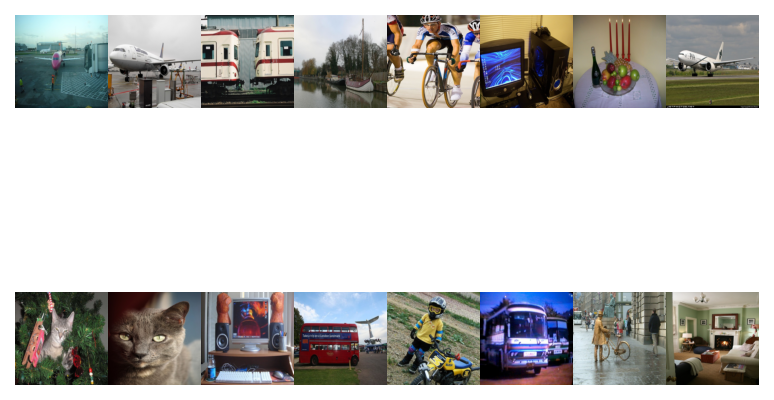

In [145]:
# Creating a VOC dataset without normalization for visualization.
train_dataset_viz = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    image_set='train',
    transform=input_resize,
    target_transform=target_resize,
)
inputs, ground_truths = map(list, zip(*[train_dataset_viz[i] for i in range(batch_size)]))

_ = plot_images(inputs)

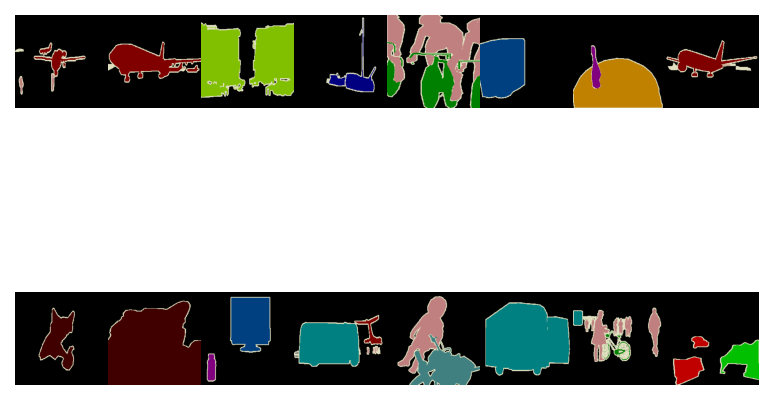

In [146]:
_ = plot_images(ground_truths)

In [147]:
# specifying loss function
criterion = smp.losses.DiceLoss('multiclass')

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet', classes=22)

# specifying optimizer
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [148]:
#callbacks

save_path = 'saves/unet-voc'

# Creating saving directory
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                    save_best_only=True, restore_best=True, verbose=True),

    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [149]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [150]:

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    criterion,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1', torchmetrics.JaccardIndex(num_classes=22, task="multiclass")],
    device=device,
)

# Train
_ = model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

Epoch:   1/100 Train steps: 22 Val steps: 3 2.02s loss: 0.665664 acc: 7.727754 fscore_macro: 0.049163 multiclass_jaccard_index: 0.027924 val_loss: 0.656463 val_acc: 9.098402 val_fscore_macro: 0.034275 val_multiclass_jaccard_index: 0.020664
Epoch 1: val_loss improved from inf to 0.65646, saving file to saves/unet-voc/best_weight.ckpt
Epoch:   2/100 Train steps: 22 Val steps: 3 1.86s loss: 0.646745 acc: 10.060019 fscore_macro: 0.067908 multiclass_jaccard_index: 0.040236 val_loss: 0.652117 val_acc: 9.316112 val_fscore_macro: 0.041959 val_multiclass_jaccard_index: 0.023955
Epoch 2: val_loss improved from 0.65646 to 0.65212, saving file to saves/unet-voc/best_weight.ckpt
Epoch:   3/100 Train steps: 22 Val steps: 3 2.12s loss: 0.689431 acc: 22.159683 fscore_macro: 0.107461 multiclass_jaccard_index: 0.064558 val_loss: 0.634251 val_acc: 27.014812 val_fscore_macro: 0.086402 val_multiclass_jaccard_index: 0.055153
Epoch 3: val_loss improved from 0.65212 to 0.63425, saving file to saves/unet-voc/b

In [151]:
from torchsummary import summary

# Get the underlying PyTorch model
torch_model = model.network

# Print model summary
summary(torch_model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Test steps: 3 0.22s test_loss: 0.492902 test_acc: 71.798340 test_fscore_macro: 0.206607 test_multiclass_jaccard_index: 0.143989
Index(['epoch', 'time', 'lr', 'loss', 'acc', 'fscore_macro',
       'multiclass_jaccard_index', 'val_loss', 'val_acc', 'val_fscore_macro',
       'val_multiclass_jaccard_index'],
      dtype='object')


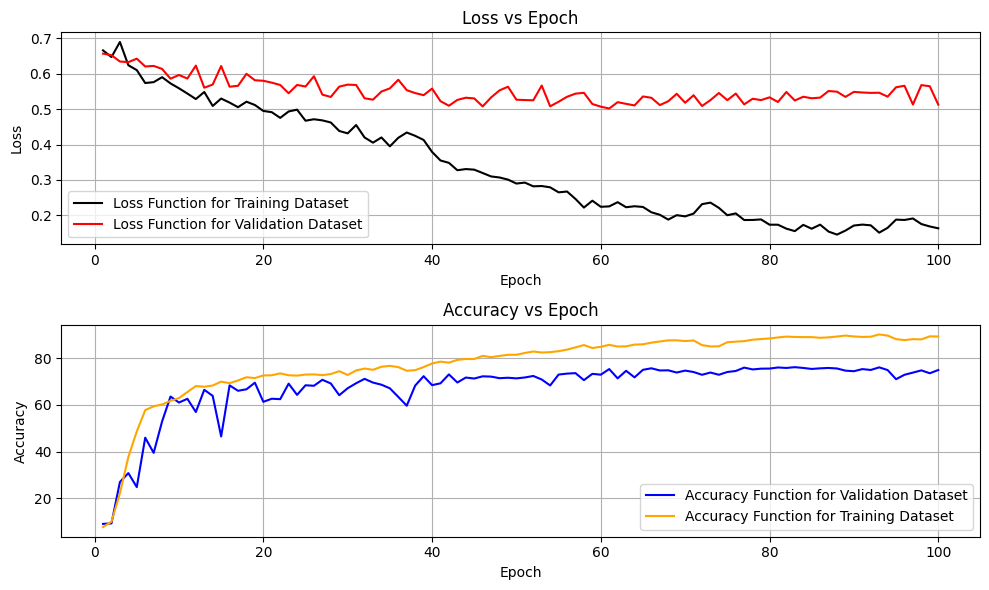

In [152]:
import pandas as pd

loss, (acc, f1, jaccard) = model.evaluate_generator(test_loader)

df = pd.read_csv('saves/unet-voc/log.tsv', delimiter='\t')
print(df.columns)

#  Prepare the data
x_values = df['epoch']  # Replace 'x_column' with the column name for the x-axis
y_values = df['loss']  # Replace 'y_column' with the column name for the y-axis

# Plot the data
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot( df['epoch'],  df['loss'], label="Loss Function for Training Dataset",color="black")
plt.plot( df['epoch'],  df['val_loss'], label="Loss Function for Validation Dataset",color="red")
plt.legend()
plt.grid(True)          # Add grid lines
plt.xlabel('Epoch')  # Replace with your desired x-axis label
plt.ylabel('Loss')  # Replace with your desired y-axis label
plt.title('Loss vs Epoch')      # Replace with your desired plot title

plt.subplot(2,1,2)
plt.plot( df['epoch'],  df['val_acc'],label="Accuracy Function for Validation Dataset",color="blue")
plt.plot( df['epoch'],  df['acc'],label="Accuracy Function for Training Dataset",color="orange")
plt.legend()
plt.grid(True)          # Add grid lines
plt.xlabel('Epoch')  # Replace with your desired x-axis label
plt.ylabel('Accuracy')  # Replace with your desired y-axis label
plt.title('Accuracy vs Epoch')      # Replace with your desired plot title

plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

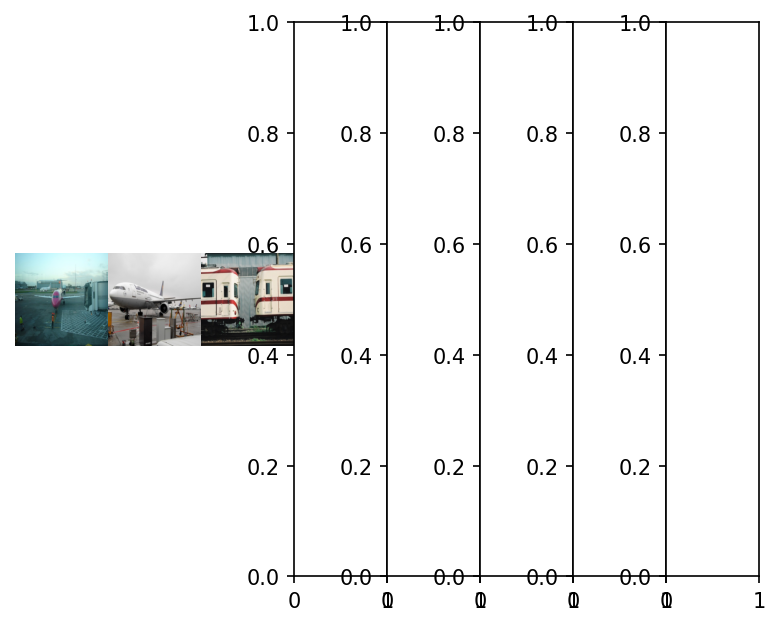

<Figure size 1000x600 with 0 Axes>

In [153]:
# Creating a VOC dataset without normalization for visualization.
test_dataset_viz = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    image_set='val',
    transform=input_resize,
    target_transform=target_resize,
)
inputs, ground_truths = map(list, zip(*[train_dataset_viz[i] for i in range(3)]))

_ = plot_images(inputs)
plt.figure(figsize=(10,6))



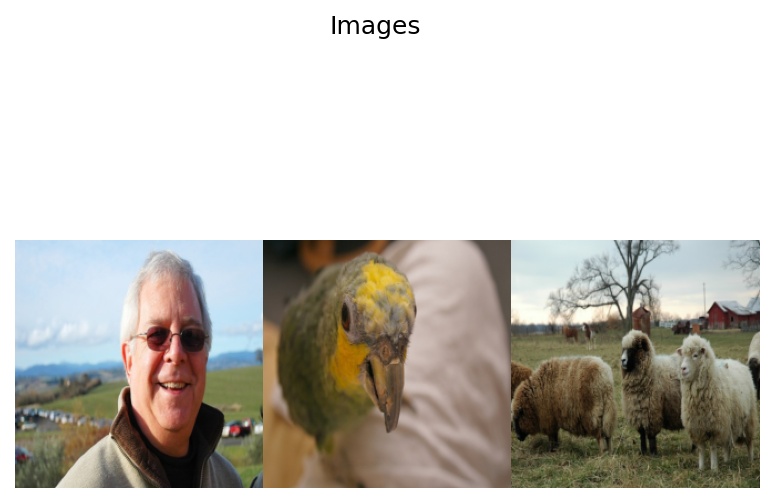

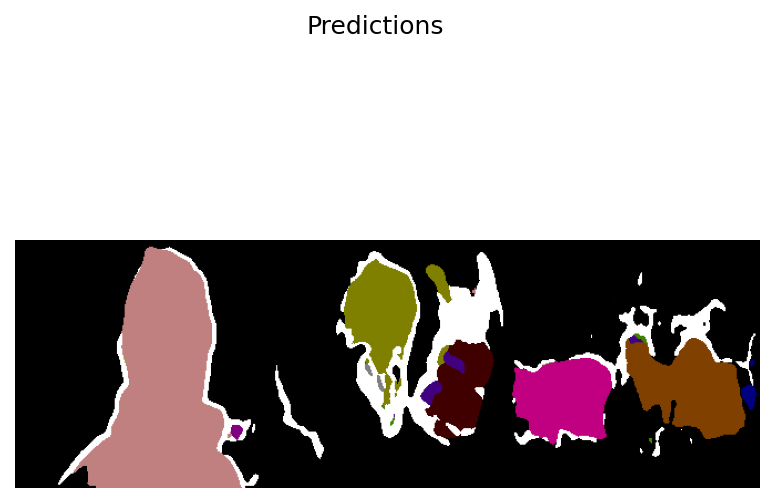

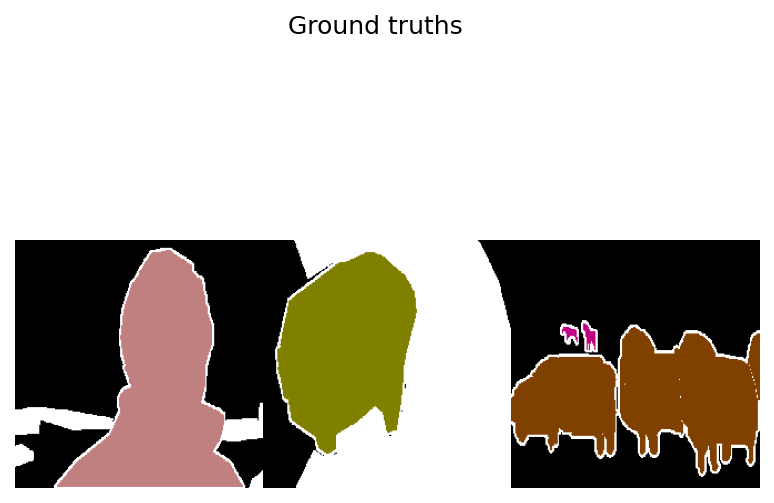

In [154]:
inputs, ground_truths = next(iter(test_loader))
outputs = model.predict_on_batch(inputs)
outputs = outputs.argmax(1)

inputs = inputs[3:6]
ground_truths = ground_truths[3:6]

outputs = replace_tensor_value_(outputs, 21, 255)
ground_truths = replace_tensor_value_(ground_truths, 21, 255)

plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs,3)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs][3:6]
fig = plot_images(pil_outputs,3)
fig.suptitle("Predictions")

pil_ground_truths = [array1d_to_pil_image(gt) for gt in ground_truths.numpy()]
fig = plot_images(pil_ground_truths,3)
_ = fig.suptitle("Ground truths")